In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/basketball-betting-dataset/basketball-final.sqlite
/kaggle/input/basketball/nba.sqlite
/kaggle/input/basketball/csv/other_stats.csv
/kaggle/input/basketball/csv/draft_history.csv
/kaggle/input/basketball/csv/team_details.csv
/kaggle/input/basketball/csv/player.csv
/kaggle/input/basketball/csv/draft_combine_stats.csv
/kaggle/input/basketball/csv/team_info_common.csv
/kaggle/input/basketball/csv/common_player_info.csv
/kaggle/input/basketball/csv/team_history.csv
/kaggle/input/basketball/csv/game.csv
/kaggle/input/basketball/csv/game_summary.csv
/kaggle/input/basketball/csv/officials.csv
/kaggle/input/basketball/csv/game_info.csv
/kaggle/input/basketball/csv/line_score.csv
/kaggle/input/basketball/csv/play_by_play.csv
/kaggle/input/basketball/csv/team.csv
/kaggle/input/basketball/csv/inactive_players.csv


I was listening to the podcast [Whistleblower](https://whistleblowerpod.com/). Tim Donaghy is a disgraced former official who was caught gambling on games he officiated. What I found interesting was that he had a high rate of success (claimed >80%) betting on games where he was not even officiating. This leads me to believe that NBA referees are not completely fair an unbiased in their officiating. If Tim Donaghy knows something about their behavior and patterns that we don't and was able to use that to successfully bet on game lines, then maybe we can extrapolate something from a dataset of NBA games!

I am working with the NBA Database I found on Kaggle. This is the best dataset I could find in terms of having the most games. However it does not have information on which referees were officiating each game or what the betting line was pre-game. We will have to find this data elsewhere and add it. I want the final working dataframe to have columns that look something like this:

In [2]:
ex_columns = ['gameid', 'date' 'home_team', 'away_team', 'closing_odds', 'result', 'crew_chief', 'official_1', 'official_2', 'official_3', 'playoffs']

# Formatting the dataframe

From the "BettingOdds_History" table in basketball-betting-dataset we can pull the date, home team, away team, and the spread at close. For the spread a negative value indicates the home team is the favorite to win. For example -7.5 means the home team is favored to beat the away team by 7.5 points.

We can use the 'Game' table to get the result of the game. It should be simple enough to add a result column to see if the spread was covered or not.

 And we can use the 'Game_Officials' table to see who the referees were in the game. This table is set up different from the others. We will have to use the 'Game_ID' column to match three officials to corresponding Game_ID in our final dataframe.

In [3]:
# Create the working dataframes with sqlite
import sqlite3
with sqlite3.connect('../input/basketball-betting-dataset/basketball-final.sqlite') as con:
    odds_history = pd.read_sql_query("SELECT * from BettingOdds_History", con)
    games = pd.read_sql_query("SELECT * from Game", con)
    officials = pd.read_sql_query("SELECT * from Game_Officials", con)

In [4]:
# Drop unused columns and convert datatypes in the games dataframe
games_df = games[['GAME_ID', 'SEASON_ID','TEAM_ABBREVIATION_HOME', 'TEAM_ABBREVIATION_AWAY', 'WL_HOME', 'PTS_HOME', 'PTS_AWAY']]
games_df = games_df.convert_dtypes()
games_df

,GAME_ID,SEASON_ID,TEAM_ABBREVIATION_HOME,TEAM_ABBREVIATION_AWAY,WL_HOME,PTS_HOME,PTS_AWAY
0,0024600001,21946,HUS,NYK,L,66,68
1,0024600004,21946,CHS,NYK,W,63,47
2,0024600003,21946,BOM,PIT,W,56,51
3,0024600002,21946,PRO,BOS,W,59,53
4,0024600005,21946,DEF,WAS,L,33,50
...,...,...,...,...,...,...,...
62857,0022100488,22021,NYK,ATL,W,101,87
62858,0022100489,22021,MIL,BOS,W,117,113
62859,0022100490,22021,PHX,GSW,L,107,116
62860,0022100491,22021,LAL,BKN,L,115,122


In [5]:
# Drop unused columns and covert datatypes in the odds dataframe
odds_df = odds_history[['GAME_ID', 'Date', 'HomeSpread_AtClose']]
odds_df = odds_df.convert_dtypes()
odds_df

,GAME_ID,Date,HomeSpread_AtClose
0,0020700001,2007-10-30 00:00:00,-13.0
1,0020700003,2007-10-30 00:00:00,-1.0
2,0020700002,2007-10-30 00:00:00,5.0
3,0020700004,2007-10-31 00:00:00,-6.5
4,0020700006,2007-10-31 00:00:00,1.5
...,...,...,...
18287,0022100460,2021-12-20 00:00:00,-9.0
18288,0022100459,2021-12-20 00:00:00,-7.5
18289,0022100461,2021-12-20 00:00:00,-12.5
18290,0022100462,2021-12-20 00:00:00,-13.5


In [6]:
# Merge games and odds in our main dataframe, 'df'
df = games_df.merge(odds_df, how = 'inner')

In [7]:
# Create a column to see if the spread covered or not 
df['Covered'] = df['PTS_AWAY'] - df['PTS_HOME'] < df['HomeSpread_AtClose']
df.head()

,GAME_ID,SEASON_ID,TEAM_ABBREVIATION_HOME,TEAM_ABBREVIATION_AWAY,WL_HOME,PTS_HOME,PTS_AWAY,Date,HomeSpread_AtClose,Covered
0,0020700003,22007,GSW,UTA,L,96,117,2007-10-30 00:00:00,-1.0,False
1,0020700001,22007,SAS,POR,W,106,97,2007-10-30 00:00:00,-13.0,False
2,0020700002,22007,LAL,HOU,L,93,95,2007-10-30 00:00:00,5.0,True
3,0020700007,22007,NJN,CHI,W,112,103,2007-10-31 00:00:00,-1.5,True
4,0020700005,22007,ORL,MIL,W,102,83,2007-10-31 00:00:00,-6.5,True


A little background on betting spreads: A negative number in the 'HomeSpread_AtClose' column means the home team is favored to win by a certain amount. For a '-7.5' spread the home team needs to win by at least 8 points to "cover the spread" for the game. A loss or a win by 6 or fewer points means they did not cover for that game. 

A positive number in the 'HomeSpread_AtClose' means just the opposite. A value of 4.5 means that the home team can win, or lose by 4 or fewer points and still cover the spread. A loss by 5 or more points means they did not cover for that game.

In [8]:
# Drop unused column and combine the firstname and lastname columns in the officials dataframe
officials['full_name'] = officials['FIRST_NAME']+ ' ' + officials['LAST_NAME']
officials = officials[['GAME_ID', 'full_name']].convert_dtypes()
officials.head()

,GAME_ID,full_name
0,0029600059,Bruce Alexander
1,0029600059,Joe Crawford
2,0029600059,Luis Grillo
3,0029600121,Tony Brothers
4,0029600121,Terry Durham


In [9]:
# There are multiple occurances of the same GAME_ID. Group by 'GAME_ID' to fix this.
officials = pd.DataFrame(officials.groupby('GAME_ID')['full_name'].apply(list))
officials = officials.reset_index()
officials


,GAME_ID,full_name
0,0020000020,"[Tommy Nunez, Jack Nies, Violet Palmer]"
1,0020000023,"[Sean Corbin, Dick Bavetta, Michael Smith]"
2,0020000057,"[Tom Washington, Marc Davis, Terry Durham]"
3,0020000089,"[Tommy Nunez, Violet Palmer, Jack Nies]"
4,0020000090,"[Ted Bernhardt, Leon Wood, Hugh Evans]"
...,...,...
22190,0029901048,"[Tim Donaghy, Monty McCutchen, Steve Javie]"
22191,0029901052,"[Sean Corbin, Ted Bernhardt, Ron Garretson]"
22192,0029901138,"[Rodney Mott, Dan Crawford, Mike Callahan]"
22193,0029901146,"[Hank Armstrong, Derrick Stafford, Jack Nies]"


In [10]:
# Break up the groupby'd dataframe so each official is in their own column
officials = (officials.join(pd.DataFrame(officials['full_name'].to_list())
                             .add_prefix('official_'))
                 .drop('full_name', axis = 1))

# There are a few instances (<30) of games with more than 3 officials. Discard that data.
officials = officials.drop(columns = ['official_3','official_4', 'official_5'])
officials

,GAME_ID,official_0,official_1,official_2
0,0020000020,Tommy Nunez,Jack Nies,Violet Palmer
1,0020000023,Sean Corbin,Dick Bavetta,Michael Smith
2,0020000057,Tom Washington,Marc Davis,Terry Durham
3,0020000089,Tommy Nunez,Violet Palmer,Jack Nies
4,0020000090,Ted Bernhardt,Leon Wood,Hugh Evans
...,...,...,...,...
22190,0029901048,Tim Donaghy,Monty McCutchen,Steve Javie
22191,0029901052,Sean Corbin,Ted Bernhardt,Ron Garretson
22192,0029901138,Rodney Mott,Dan Crawford,Mike Callahan
22193,0029901146,Hank Armstrong,Derrick Stafford,Jack Nies


In [11]:
df = df.merge(officials, on='GAME_ID')
df.dropna(inplace=True)

In [12]:
# Convert datatypes of columns

df = df.convert_dtypes()
df['GAME_ID'] = df['GAME_ID'].astype('int')
df['SEASON_ID'] = df['SEASON_ID'].astype('int')
df['Date'] = pd.to_datetime(df['Date'])

# Covert our outcome columns with two vales (W/L, True/False) to int because this is preferred for predictions 
df['Covered'] = df['Covered'].astype('int')
df.replace({'WL_HOME': {'W': 1, 'L': 0}}, inplace=True)

In [13]:
# Convert some columns names into categorical variables. This saves memory and signals to python ML libraries that these columns should be treated as categorical.
cols = ['SEASON_ID', 'TEAM_ABBREVIATION_HOME', 'TEAM_ABBREVIATION_AWAY', 'official_0', 'official_1', 'official_2']
for col in cols:
    df[col] = df[col].astype('category')
df.dtypes

GAME_ID                            int64
SEASON_ID                       category
TEAM_ABBREVIATION_HOME          category
TEAM_ABBREVIATION_AWAY          category
WL_HOME                            int64
PTS_HOME                           Int64
PTS_AWAY                           Int64
Date                      datetime64[ns]
HomeSpread_AtClose               Float64
Covered                            int64
official_0                      category
official_1                      category
official_2                      category
dtype: object

# EDA

In [14]:
# graph who reffed the most games

Let's look at games where Scott Foster was a ref to see if there is a trend for teams covering or not. It is implied in the podcast that Scott Foster could have been collaborating with Donaghy. If he was a good cheater we shouldn't see a trend, because he would randomly decide whether the spread covered or not. The cheating is only occured during the '06-'07 seasons. So we will cut down the df to games Foster reffed during that season. 

In [15]:
foster_df = df.loc[(df['official_0'] == 'Scott Foster') | (df['official_1'] == 'Scott Foster') | (df['official_2'] == 'Scott Foster')]
foster_df = foster_df.loc[foster_df['SEASON_ID'] == 22007]
foster_df

,GAME_ID,SEASON_ID,TEAM_ABBREVIATION_HOME,TEAM_ABBREVIATION_AWAY,WL_HOME,PTS_HOME,PTS_AWAY,Date,HomeSpread_AtClose,Covered,official_0,official_1,official_2
26,20700015,22007,CHA,MIL,1,102,99,2007-11-02,-4.0,0,Luis Grillo,Brian Forte,Scott Foster
27,20700028,22007,PHI,NJN,0,88,93,2007-11-03,3.0,0,Scott Foster,Phil Robinson,Courtney Kirkland
45,20700049,22007,CHI,LAC,0,91,97,2007-11-06,-8.5,0,Scott Foster,Matt Boland,James Capers
74,20700071,22007,WAS,DEN,0,92,118,2007-11-09,2.0,0,James Capers,Scott Foster,Eric Lewis
87,20700087,22007,NYK,MIA,0,72,75,2007-11-11,-3.0,0,Scott Foster,Eric Lewis,David Jones
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,20701138,22007,PHI,ATL,0,85,92,2008-04-05,-5.5,0,Scott Foster,Rodney Mott,Tommy Nunez Jr.
1160,20701153,22007,CHA,MIN,1,121,119,2008-04-08,-4.5,0,Scott Foster,Bennie Adams,Courtney Kirkland
1175,20701187,22007,LAL,NOH,1,107,104,2008-04-11,-5.0,0,David Jones,Scott Foster,Tommy Nunez Jr.
1186,20701195,22007,POR,DAL,1,108,105,2008-04-12,1.5,1,Scott Foster,David Jones,Tommy Nunez Jr.


In [16]:
foster_df.value_counts()

GAME_ID   SEASON_ID  TEAM_ABBREVIATION_HOME  TEAM_ABBREVIATION_AWAY  WL_HOME  PTS_HOME  PTS_AWAY  Date        HomeSpread_AtClose  Covered  official_0    official_1    official_2       
20700015  22007      CHA                     MIL                     1        102       99        2007-11-02  -4.0                0        Luis Grillo   Brian Forte   Scott Foster         1
20700742  22007      UTA                     CHI                     1        97        87        2008-02-09  -12.0               0        Scott Foster  Rodney Mott   John Goble           1
20700884  22007      GSW                     POR                     1        110       104       2008-03-02  -6.5                0        John Goble    Jack Nies     Scott Foster         1
20700866  22007      DEN                     LAC                     1        110       104       2008-02-29  -14.0               0        Jack Nies     Scott Foster  John Goble           1
20700838  22007      MIA                     SAC       

In [17]:
# graph home teams for Foster and whether they covered or not
foster_df.groupby('TEAM_ABBREVIATION_HOME').sum()

,GAME_ID,WL_HOME,PTS_HOME,PTS_AWAY,HomeSpread_AtClose,Covered
TEAM_ABBREVIATION_HOME,,,,,,
ATL,62101559,2,310,301,-17.5,1
BKN,0,0,0,0,0.0,0
BOS,20700280,1,112,84,-12.0,1
CHA,103502441,3,521,520,-8.5,2
CHI,41401065,0,171,199,-3.5,0
CLE,0,0,0,0,0.0,0
DAL,41401054,2,196,176,-23.0,1
DEN,41401602,2,221,204,-25.0,0
DET,82802921,2,382,349,-25.5,2


In [18]:
# graph home teams for Foster and whether they won or not

# Preprocessing
Last bit of preparation to do before applying ML models

In [19]:
import os
import random

from sklearn.model_selection import train_test_split
from category_encoders import HashingEncoder

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    
SEED = 42
set_seed(SEED)

In [20]:
# train/test split

dependent_variables = ['SEASON_ID','TEAM_ABBREVIATION_HOME','TEAM_ABBREVIATION_AWAY','HomeSpread_AtClose','official_0','official_1','official_2']
X = df[dependent_variables]
y = df['Covered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = SEED)

In [21]:
# We create a helper function to get the scores for each encoding method:
from sklearn.metrics import roc_auc_score

def get_score(model, X, y, X_val, y_val):
    model.fit(X, y)
    y_pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, y_pred)
    return score

In [22]:
# We have categorical columns with high cardinality that we need to convert into something numerical before we use ML models. A hash encoder would work best for this case 

hash_columns = ['SEASON_ID','TEAM_ABBREVIATION_HOME','TEAM_ABBREVIATION_AWAY','official_0','official_1','official_2']

# hyperparameter list
n_components_list = [100, 500, 1000, 5000, 10000]
n_components_list_str = [str(i) for i in n_components_list]

fh_rf_scores = []
rf = RandomForestClassifier(random_state=SEED)

for n_components in n_components_list:
    
    hashing_enc = HashingEncoder(cols=hash_columns, n_components=n_components).fit(X_train, y_train)
    
    X_train_hashing = hashing_enc.transform(X_train.reset_index(drop=True))
    X_test_hashing = hashing_enc.transform(X_test.reset_index(drop=True))
    
    fe_rf_score = get_score(rf, X_train_hashing, y_train, X_test_hashing, y_test)
    fh_rf_scores.append(fe_rf_score)

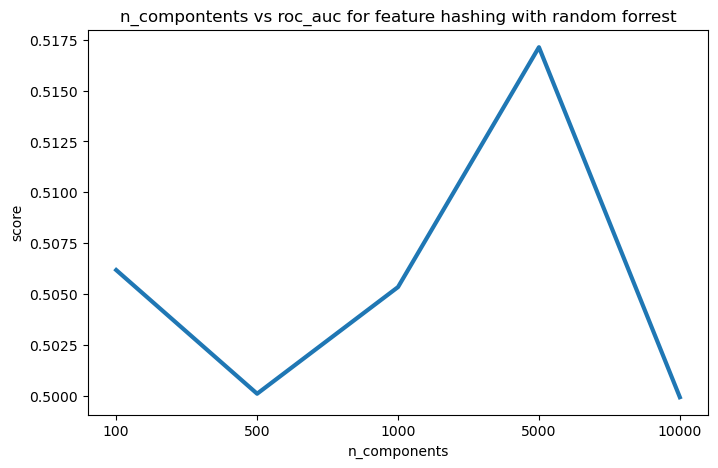

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(n_components_list_str, fh_rf_scores, linewidth=3)
plt.title('n_compontents vs roc_auc for feature hashing with random forrest')
plt.xlabel('n_components')
plt.ylabel('score')
plt.show;

In [24]:
# we can see that 5000 is the sweetspot for n_components
n_components=5000
hashing_enc = HashingEncoder(cols=hash_columns, n_components=n_components).fit(X_train, y_train)
    
X_train = hashing_enc.transform(X_train.reset_index(drop=True))
X_test = hashing_enc.transform(X_test.reset_index(drop=True))

# Applying ML models
Using GridSearch
Code mostly taken from https://www.kaggle.com/code/ihelon/titanic-hyperparameter-tuning-with-gridsearchcv

In [25]:
cross_valid_scores = {}

In [26]:
%%time
# Decision tree

parameters = {
    "max_depth": [3, 5, 7, 9, 11, 13],
}

model_desicion_tree = DecisionTreeClassifier(
    random_state=SEED,
    class_weight='balanced',
)

model_desicion_tree = GridSearchCV(
    model_desicion_tree, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_desicion_tree.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_desicion_tree.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + \
    f'{model_desicion_tree.best_score_:.3f}'
)
cross_valid_scores['desicion_tree'] = model_desicion_tree.best_score_
print('-----')

-----
Best parameters {'max_depth': 13}
Mean cross-validated accuracy score of the best_estimator: 0.504
-----
CPU times: user 1min 40s, sys: 11.2 s, total: 1min 51s
Wall time: 1min 51s


In [27]:
%%time
# Random forest

parameters = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 13],
}

model_random_forest = RandomForestClassifier(
    random_state=SEED,
    class_weight='balanced',
)

model_random_forest = GridSearchCV(
    model_random_forest, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_random_forest.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_random_forest.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_random_forest.best_score_:.3f}'
)
cross_valid_scores['random_forest'] = model_random_forest.best_score_
print('-----')

-----
Best parameters {'max_depth': 5, 'n_estimators': 5}
Mean cross-validated accuracy score of the best_estimator: 0.518
-----
CPU times: user 8min 19s, sys: 55 s, total: 9min 14s
Wall time: 9min 14s


In [28]:
%%time
# XGBoost

parameters = {
    'max_depth': [3, 5, 7, 9], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

model_xgb = xgb.XGBClassifier(
    random_state=SEED,
)

model_xgb = GridSearchCV(
    model_xgb, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_xgb.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_xgb.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_xgb.best_score_:.3f}'
)
cross_valid_scores['xgboost'] = model_xgb.best_score_
print('-----')

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
420 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
420 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 1397, in fit
    enable_categorical=self.enable_categorical,
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:HomeSpread_AtClose

In [ ]:
%%time
# SVC

parameters = {
    "C": [0.001, 0.01, 0.1, 1.],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
}

model_svc = SVC(
    random_state=SEED,
    class_weight="balanced",
    probability=True,
)

model_svc = GridSearchCV(
    model_svc, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_svc.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_svc.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_svc.best_score_:.3f}'
)
cross_valid_scores['svc'] = model_svc.best_score_
print('-----')

In [ ]:
%%time
# KNN

parameters = {
    "weights": ["uniform", "distance"],
}

model_k_neighbors = KNeighborsClassifier(
)

model_k_neighbors = GridSearchCV(
    model_k_neighbors, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_k_neighbors.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_k_neighbors.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_k_neighbors.best_score_:.3f}'
)
cross_valid_scores['k_neighbors'] = model_k_neighbors.best_score_
print('-----')

In [ ]:
%%time
# Logistic Regression

parameters = {
    "C": [0.001, 0.01, 0.1, 1.],
    "penalty": ["l1", "l2"]
}

model_logistic_regression = LogisticRegression(
    random_state=SEED,
    class_weight="balanced",
    solver="liblinear",
)

model_logistic_regression = GridSearchCV(
    model_logistic_regression, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_logistic_regression.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_logistic_regression.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_logistic_regression.best_score_:.3f}'
)
cross_valid_scores['logistic_regression'] = model_logistic_regression.best_score_
print('-----')